# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science: 

## Homework 2: Linear and k-NN Regression


**Harvard University**<br/>
**Fall 2018**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader

<hr style="height:2pt">


In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- To submit your assignment follow the instructions given in canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 
- As much as possible, try and stick to the hints and functions we import at the top of the homework, as those are the ideas and tools the class supports and is aiming to teach. And if a problem specifies a particular library you're required to use that library, and possibly others from the import list.

Names of people you have worked with goes here: 

Avriel Epps & Erin Williams

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.api import OLS
import seaborn as sns
from pandas.core import datetools
%matplotlib inline

/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


<div class="theme"> Predicting Taxi Pickups in NYC </div>

In this homework, we will explore k-nearest neighbor and linear regression methods for predicting a quantitative variable. Specifically, we will build regression models that can predict the number of taxi pickups in New York city at any given time of the day. These prediction models will be useful, for example, in monitoring traffic in the city.

The data set for this problem is given in the file `dataset_1.csv`.  You will need to separate it into training and test sets. The first column contains the time of a day in minutes, and the second column contains the number of pickups observed at that time. The data set covers taxi pickups recorded in NYC during Jan 2015.

We will fit regression models that use the time of the day (in minutes) as a predictor and predict the average number of taxi pickups at that time. The models will be fitted to the training set and  evaluated on the test set. The performance of the models will be evaluated using the $R^2$ metric.

<div class="exercise"> <b> Question 1  [25 pts]</b> </div>

**1.1**. Use pandas to load the dataset from the csv file `dataset_1.csv` into a pandas data frame.  Use the `train_test_split` method from `sklearn` with a `random_state` of 42 and a `test_size` of 0.2 to split the dataset into training and test sets.  Store your train set dataframe in the variable `train_data`.  Store your test set dataframe in the variable `test_data`.


**1.2**. Generate a scatter plot of the training data points with clear labels on the x and y axes. The time of the day on the x-axis and the number of taxi pickups on the y-axis.  Make sure to title your plot.

**1.3**. Does the pattern of taxi pickups make intuitive sense to you? 


### Answers

**1.1 Use pandas to load the dataset from the csv file ...**

In [3]:
# read the file
data = pd.read_csv('data/dataset_1.csv', sep=",")


In [4]:
print(data.columns)

Index(['TimeMin', 'PickupCount'], dtype='object')


In [5]:
#Check that it imported correctly -- delete before turning in
display(data.head())

,TimeMin,PickupCount
0,860.0,33.0
1,17.0,75.0
2,486.0,13.0
3,300.0,5.0
4,385.0,10.0


In [6]:
#data['Time (TimeMin)'].astype(str)
#data['Pick Up Count'].astype(str)

In [7]:
# split the data
train_data, test_data = train_test_split(data, test_size = 0.2, random_state = 42)

In [8]:
x_train, y_train = train_data['TimeMin'], train_data['PickupCount']
x_test, y_test = test_data['TimeMin'], test_data['PickupCount']

In [9]:
# Test size is indeed 20% of total
data20 = .2*len(data)
our20 = len(test_data)
display("20% of data:",data20,"Our split data:", our20)

'20% of data:'

250.0

'Our split data:'

250

**1.2 Generate a scatter plot of the training data points**

In [10]:
#sns.relplot(x="Time of Day", y="Number of Pickups", data=train_data)

In [11]:
def nice_scatterplot(x, y, title):
    # font size
    f_size = 18
    
    # make the figure
    fig, ax = plt.subplots(1,1, figsize=(8,5)) # Create figure object

    # set axes limits to make the scale nice
    ax.set_xlim(np.min(x)-1, np.max(x) + 1)
    ax.set_ylim(np.min(y)-1, np.max(y) + 1)

    # adjust size of tickmarks in axes
    ax.tick_params(labelsize = f_size)
    
    # remove tick labels
    ax.tick_params(labelbottom=False,  bottom=False)
    
    # adjust size of axis label
    ax.set_xlabel(r'$x$', fontsize = f_size)
    ax.set_ylabel(r'$y$', fontsize = f_size)
    
    # set figure title label
    ax.set_title(title, fontsize = f_size)

    # you may set up grid with this 
    ax.grid(True, lw=1.75, ls='--', alpha=0.15)

    # make actual plot (Notice the label argument!)
    #ax.scatter(x, y, label=r'$my points$')
    #ax.scatter(x, y, label='$my points$')
    ax.scatter(x, y, label=r'$my\,points$')
    ax.legend(loc='best', fontsize = f_size);
    
    return ax

Text(0,0.5,'Number of Taxi Pick Ups')

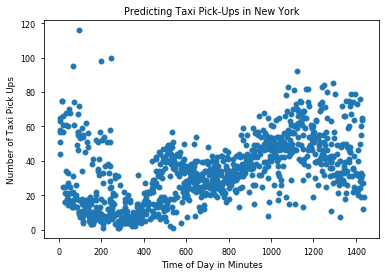

In [12]:
sns.set_context("paper")
plt.scatter(x_train,y_train)
plt.title('Predicting Taxi Pick-Ups in New York')
plt.xlabel("Time of Day in Minutes")
plt.ylabel("Number of Taxi Pick Ups")

**1.3 Discuss your results. Does the pattern of taxi pickups make intuitive sense to you?**

Yes, there are very few pickups occurring early in the morning; pickups begin to spike during rush hour/during the work day, and begin to drop off again into the night. The graph displays from 12:00am to 11:59pm, so we see that the data at the beginning of the plot where x = 0 marries up nicely with the end of the plot where x = 11:59, which we expect because time of day is a continuous loop.


<div class="exercise"> <b>Question 2 [25 pts]</b> </div>

In lecture we've seen k-Nearest Neighbors (k-NN) Regression, a non-parametric regression technique.  In the following problems please use built in functionality from `sklearn` to run k-NN Regression. 


**2.1**. Choose `TimeMin` as your feature variable and `PickupCount` as your response variable.  Create a dictionary of `KNeighborsRegressor` objects and call it `KNNModels`.  Let the key for your `KNNmodels` dictionary be the value of $k$ and the value be the corresponding `KNeighborsRegressor` object. For $k \in \{1, 10, 75, 250, 500, 750, 1000\}$, fit k-NN regressor models on the training set (`train_data`). 

**2.2**.  For each $k$ on the training set, overlay a scatter plot of the actual values of `PickupCount` vs. `TimeMin` with a scatter plot of **predictions** for `PickupCount` vs  `TimeMin`.  Do the same for the test set.  You should have one figure with 2 x 7 total subplots; for each $k$ the figure should have two subplots, one subplot for the training set and one for the test set. 

**Hints**:
1. Each subplot should use different color and/or markers to distinguish k-NN regression prediction values from the actual data values.
2. Each subplot must have appropriate axis labels, title, and legend.
3. The overall figure should have a title.  


**2.3**. Report the $R^2$ score for the fitted models on both the training and test sets for each $k$ (reporting the values in tabular form is encouraged).

**2.4**. Plot, in a single figure, the $R^2$ values from the model on the training and test set as a function of $k$.  

**Hints**:
1. Again, the figure must have axis labels and a legend.
2. Differentiate $R^2$ visualization on the training and test set by color and/or marker.
3. Make sure the $k$ values are sorted before making your plot.

**2.5**. Discuss the results:

1. If $n$ is the number of observations in the training set, what can you say about a k-NN regression model that uses $k = n$?  
2. What does an $R^2$ score of $0$ mean?  
3. What would a negative $R^2$ score mean?  Are any of the calculated $R^2$ you observe negative?
4. Do the training and test $R^2$ plots exhibit different trends?  Describe.  
5. How does the value of $k$ affect the fitted model and in particular the training and test $R^2$ values?
6. What is the best value of $k$ and what are the corresponding training/test set $R^2$ values?

### Answers

**2.1 Choose `TimeMin` as your feature variable and `PickupCount` as your response variable.  Create a dictionary ... **

In [13]:
# Set kNN parameter:
k = 10

# Now we can fit the model, predict our variable of interest, and then evaluate our fit:
# First, we create the classifier object:
neighbors = KNeighborsRegressor(n_neighbors=k)

# Then, we fit the model using x_train as training data and y_train as target values:
neighbors.fit(train_data[['TimeMin']], train_data['PickupCount'])

neighbors

# Retreieve our predictions:
prediction_knn = neighbors.predict(test_data[['TimeMin']])

#put this in a function
def get_knn(k):
    neighbors = KNeighborsRegressor(n_neighbors=k)
    neighbors.fit(train_data[['TimeMin']], train_data['PickupCount'])
    return neighbors

In [14]:
KNNModels = {}
KNNModels['1']=get_knn(k=1)
KNNModels['10']=get_knn(k=10)
KNNModels['75']=get_knn(k=75)
KNNModels['250']=get_knn(k=250)
KNNModels['500']=get_knn(k=500)
KNNModels['750']=get_knn(k=750)
KNNModels['1000']=get_knn(k=1000)

KNNModels

{'1': KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform'),
 '10': KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='uniform'),
 '1000': KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1000, p=2,
           weights='uniform'),
 '250': KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=250, p=2,
           weights='uniform'),
 '500': KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=500, p=2,
           weights='uniform'),
 '75': KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=75

**2.2 For each $k$ on the training set, overlay a scatter plot ... **

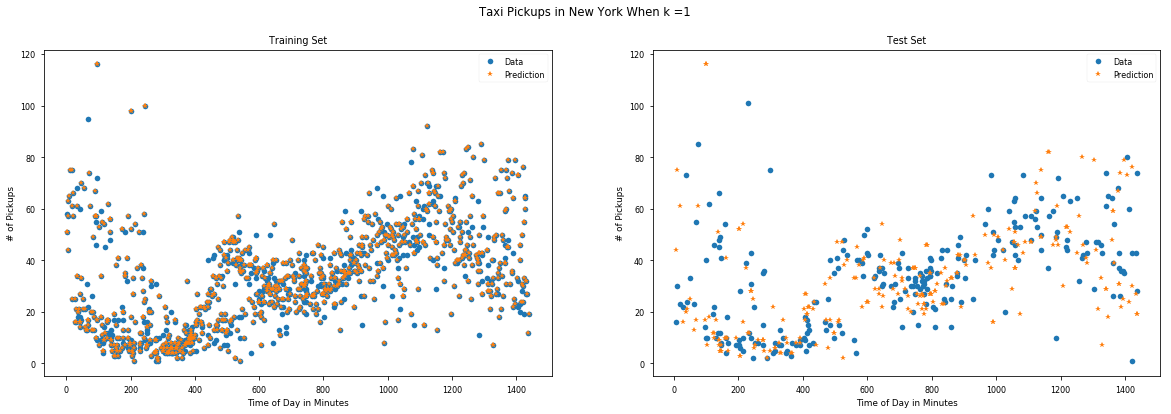

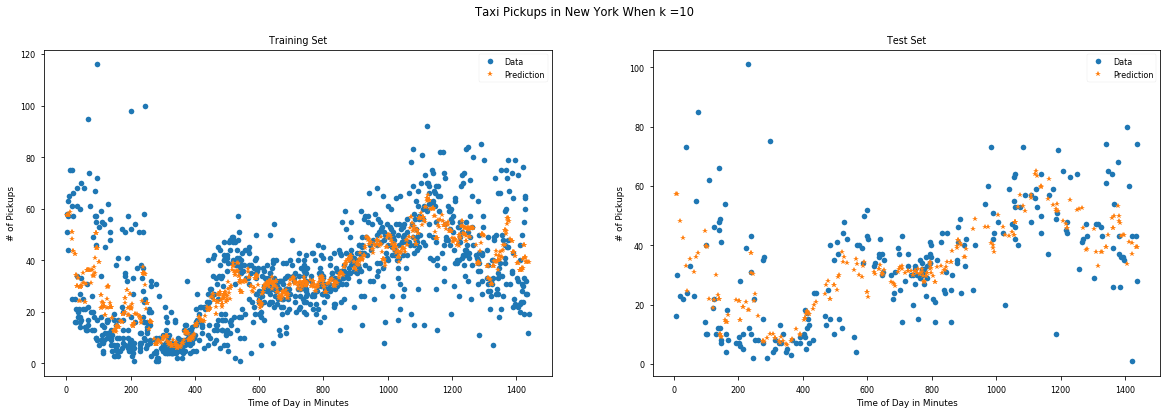

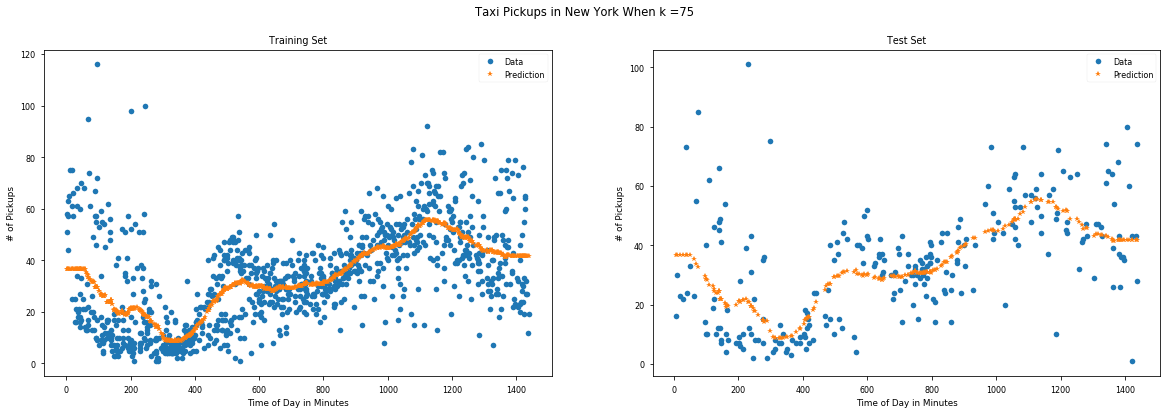

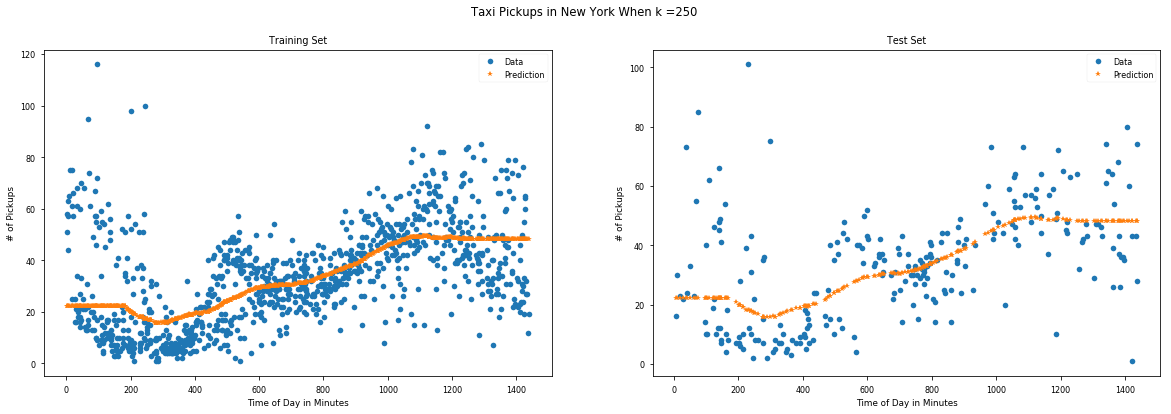

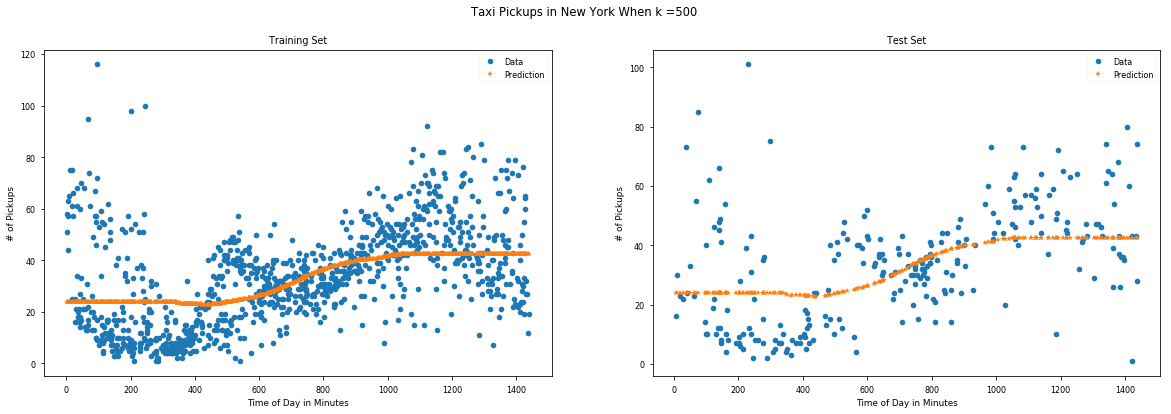

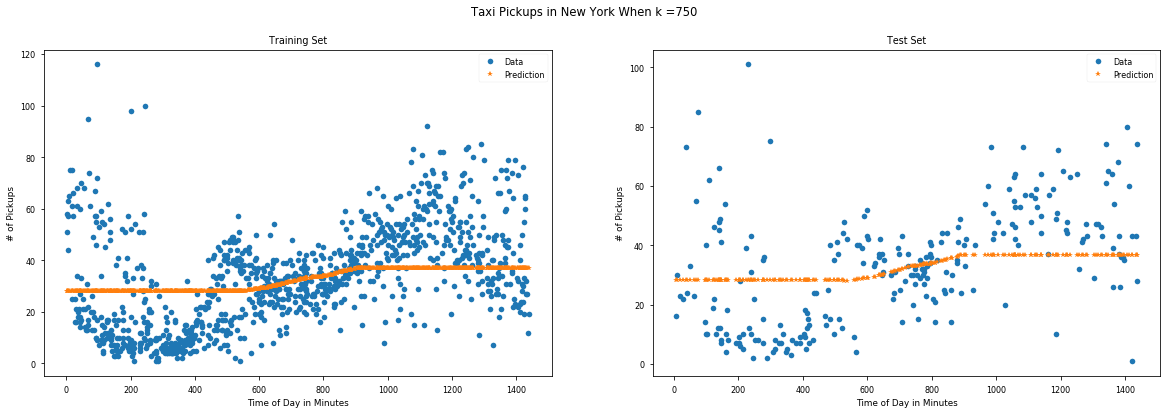

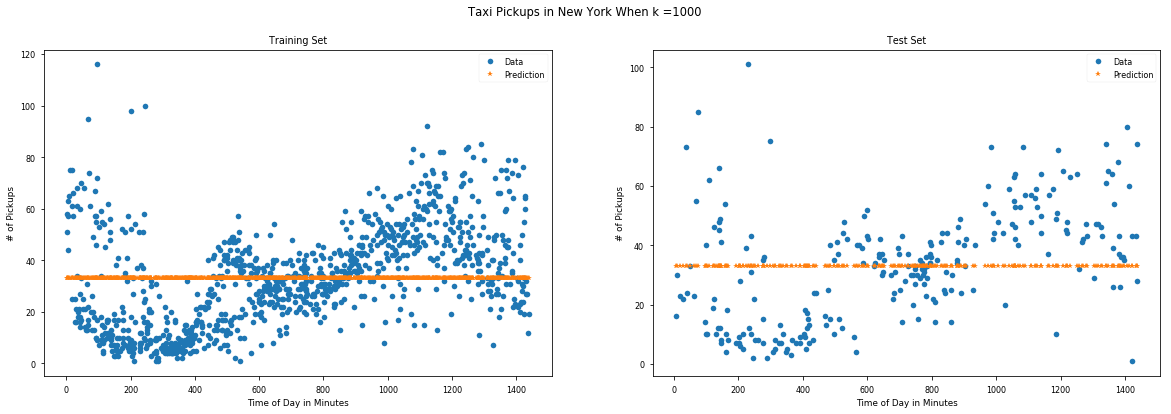

In [15]:
for k in (1, 10, 75, 250, 500, 750, 1000):
    neighbors = get_knn(k)

    # Then, we fit the model using x_train as training data and y_train as target values:
    neighbors.fit(train_data[['TimeMin']], train_data['PickupCount'])

    # Retreieve our predictions:
    prediction_knn = neighbors.predict(test_data[['TimeMin']])

    #plot
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,6))
    axes[0].plot(train_data['TimeMin'], train_data['PickupCount'], 'o', label = 'Data' )
    axes[0].plot(train_data['TimeMin'], neighbors.predict(train_data[['TimeMin']]), '*', label = 'Prediction')
    axes[0].set_xlabel('Time of Day in Minutes')
    axes[0].set_ylabel('# of Pickups')
    axes[0].set_title("Training Set")
    axes[0].legend()

    axes[1].plot(test_data['TimeMin'], test_data['PickupCount'],'o', label = 'Data' )
    axes[1].plot(test_data['TimeMin'], prediction_knn, '*', label = 'Prediction')
    axes[1].set_xlabel('Time of Day in Minutes')
    axes[1].set_ylabel('# of Pickups')
    axes[1].set_title("Test Set")
    axes[1].legend()

    fig.suptitle(f"Taxi Pickups in New York When k ={k}");

**2.3 Report the $R^2$ score for the fitted models ... **

In [16]:
def get_r_2(k):
    array_train, array_test = [],[]
    for k in (1, 10, 75, 250, 500, 750, 1000):
        neighbors = get_knn(k)
        r2_train = neighbors.score(train_data[['TimeMin']], train_data['PickupCount'])
        r2_test = neighbors.score(test_data[['TimeMin']], test_data['PickupCount'])
        print("Length of Test Data:", len(test_data['PickupCount']))
        print("k:", k)
        print("R^2 Score of kNN on test set:", r2_test)
        print("R^2 Score of kNN on training set:", r2_train)
        print("\n")
        array_train.append(r2_train)
        array_test.append(r2_test)
    return array_train, array_test
    
    
array_train, array_test = get_r_2(k)
    

Length of Test Data: 250
k: 1
R^2 Score of kNN on test set: -0.418931841503
R^2 Score of kNN on training set: 0.712335924955


Length of Test Data: 250
k: 10
R^2 Score of kNN on test set: 0.272067980041
R^2 Score of kNN on training set: 0.509825354306


Length of Test Data: 250
k: 75
R^2 Score of kNN on test set: 0.390309796916
R^2 Score of kNN on training set: 0.445391989803


Length of Test Data: 250
k: 250
R^2 Score of kNN on test set: 0.340340836744
R^2 Score of kNN on training set: 0.355313771062


Length of Test Data: 250
k: 500
R^2 Score of kNN on test set: 0.270320835257
R^2 Score of kNN on training set: 0.29032710754


Length of Test Data: 250
k: 750
R^2 Score of kNN on test set: 0.164909392671
R^2 Score of kNN on training set: 0.179433813562


Length of Test Data: 250
k: 1000
R^2 Score of kNN on test set: -0.000384330376417
R^2 Score of kNN on training set: 0.0




**2.4 Plot, in a single figure, the $R^2$ values from the model on the training and test set as a function of $k$**

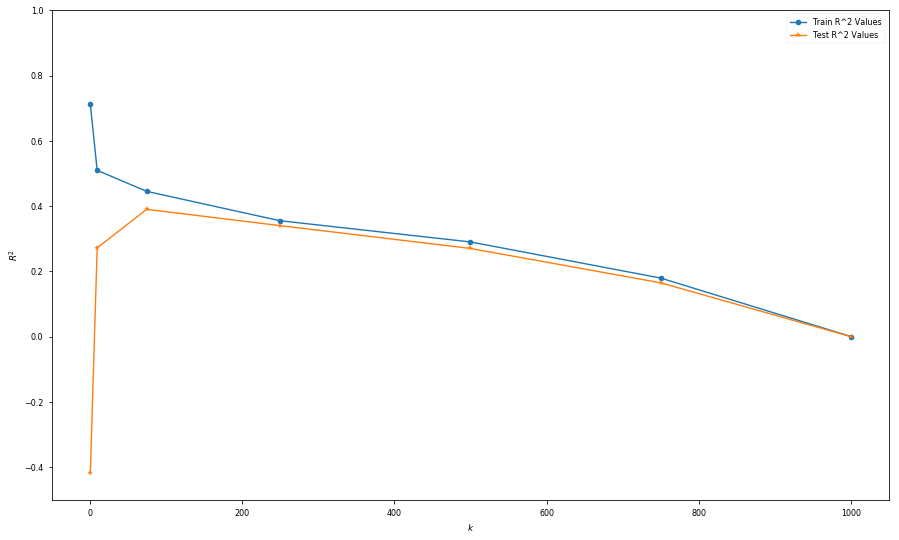

In [17]:
ks = [1, 10, 75, 250, 500, 750, 1000]
fig, ax = plt.subplots(1,1, figsize=(15,9))
ax.plot(ks, array_train,'-o', label = 'Train R^2 Values' )
ax.plot(ks, array_test,'-*', label = 'Test R^2 Values' )
ax.set_xlabel(r'$k$')
ax.set_ylim([-0.5, 1])
ax.set_ylabel(r'$R^{2}$')
ax.legend()

**2.5 Discuss the results**

1. If $n$ is the number of observations in the training set, what can you say about a k-NN regression model that uses $k = n$?  
2. What does an $R^2$ score of $0$ mean?  
3. What would a negative $R^2$ score mean?  Are any of the calculated $R^2$ you observe negative?
4. Do the training and test $R^2$ plots exhibit different trends?  Describe.  
5. How does the value of $k$ affect the fitted model and in particular the training and test $R^2$ values?
6. What is the best value of $k$ and what are the corresponding training/test set $R^2$ values?

**Answers to Discussion Questions**
1. If k = n, the model will become a straight horizontal line. The model will be a straight horizontal line at the average of the observed response.
2. $R^2$ is a value between 0 and 1, where 1 represents the best fit model. And $R^2$ of 0 tells us that our model is as good as taking the mean value for the available data.
3. It means that our model is worse than the mean, which typically only occurs when we evaluate the model within the test set, because the data is so closely fitted to the train set.
4. In the first model, where k = 1, the model performs worse than the average for the test set. It performs much better than the average for the train set. As the k value increases, both models trend toward 0.
5. The higher the value of k, the closer the models move toward the mean. As k increases, $R^2$ trends toward 0.
6. We believe the best value of k is 75. At k = 1 and k = 10, the $R^2$ values are still far apart. At k = 75, they are int he range of 0.4, and above k = 75 we see that the $R^2$ of the train and the test start to go down.

<div class="exercise"> <b> Question 3 [25 pts] </b></div>

We next consider simple linear regression, which we know from lecture is a parametric approach for regression that assumes that the response variable has a linear relationship with the predictor.  Use the `statsmodels` module for Linear Regression. This module has built-in functions to summarize the results of regression and to compute confidence intervals for estimated regression parameters.  

**3.1**. Again choose `TimeMin` as your predictor and `PickupCount` as your response variable.  Create a `OLS` class instance and use it to fit a Linear Regression model on the training set (`train_data`).  Store your fitted model in the variable `OLSModel`.

**3.2**. Re-create your plot from 2.2 using the predictions from `OLSModel` on the training and test set. You should have one figure with two subplots, one subplot for the training set and one for the test set.

**Hints**:
1. Each subplot should use different color and/or markers to distinguish Linear Regression prediction values from that of the actual data values.
2. Each subplot must have appropriate axis labels, title, and legend.
3. The overall figure should have a title.  


**3.3**. Report the $R^2$ score for the fitted model on both the training and test sets.

**3.4**. Report the slope and intercept values for the fitted linear model.  

**3.5**. Report the $95\%$ confidence interval for the slope and intercept.

**3.6**. Create a scatter plot of the residuals ($e = y - \hat{y}$) of the linear regression model on the training set as a function of the predictor variable (i.e. `TimeMin`). Place on your plot a horizontal line denoting the constant zero residual.  

**3.7**. Discuss the results:

1. How does the test $R^2$ score compare with the best test $R^2$ value obtained with k-NN regression?
2. What does the sign of the slope of the fitted linear model convey about the data?  
3. Based on the $95\%$ confidence interval, do you consider the estimates of the model parameters to be reliable?  
4. Do you expect $99\%$ confidence intervals for the slope and intercept to be tighter or wider than the $95\%$ confidence intervals? Briefly explain your answer.  
5. Based on the residuals plot that you made, discuss whether or not the assumption of linearity is valid for this data.
6. Based on the data structure, what restriction on the model would you put at the endpoints (at $x\approx0$ and $x\approx1440$)?   What does this say about the linearity assumption?


### Answers

**3.1 Again choose `TimeMin` as your predictor and `PickupCount` as your response variable.  Create a `OLS` class instance ... **

In [18]:
#Add constant
x_ca = sm.add_constant(data['TimeMin'])
x_train_ca = sm.add_constant(x_train)
x_test_ca = sm.add_constant(x_test)

#We must first create the linear regression object from stats model
OLSmodel = sm.OLS(y_train, x_train_ca)
results = OLSmodel.fit()
display(results.summary())

#predict y
predicted_y = results.predict(x_ca)
predicted_y_train = results.predict(x_train_ca)
predicted_y_test = results.predict(x_test_ca)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            PickupCount   R-squared:                       0.243
Model:                            OLS   Adj. R-squared:                  0.242
Method:                 Least Squares   F-statistic:                     320.4
Date:                Thu, 27 Sep 2018   Prob (F-statistic):           2.34e-62
Time:                        12:08:56   Log-Likelihood:                -4232.9
No. Observations:                1000   AIC:                             8470.
Df Residuals:                     998   BIC:                             8480.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         16.7506      1.058     15.838      0.000      14.675      18.826
TimeMin        0.0233      0.001     17.900      0.000       0.021       0.026
==============================================================================
Omnibus:                      203.688   Durbin-Watson:                   1.910
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              462.910
Skew:                           1.111   Prob(JB):                    3.02e-101
Kurtosis:                       5.485   Cond. No.                     1.63e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.63e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**3.2 Re-create your plot from 2.2 using the predictions from `OLSModel` on the training and test set ... **

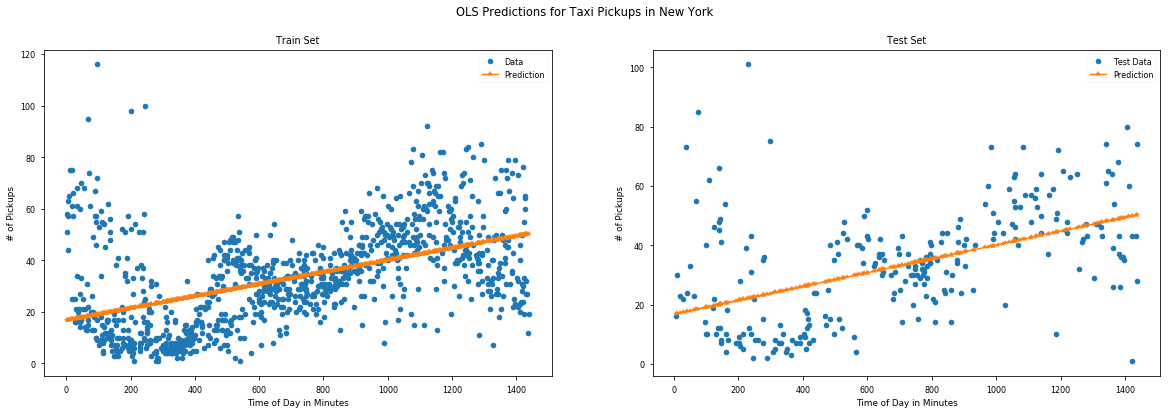

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,6))
axes[0].plot(train_data['TimeMin'], train_data['PickupCount'],'o', label = 'Data' )
axes[0].plot(train_data['TimeMin'], predicted_y_train, '-*', label = 'Prediction')
axes[0].set_xlabel('Time of Day in Minutes')
axes[0].set_ylabel('# of Pickups')
axes[0].set_title("Train Set")
axes[0].legend()

axes[1].plot(test_data['TimeMin'], test_data['PickupCount'], 'o', label = 'Test Data' )
axes[1].plot(test_data['TimeMin'], predicted_y_test, '-*', label = 'Prediction')
axes[1].set_xlabel('Time of Day in Minutes')
axes[1].set_ylabel('# of Pickups')
axes[1].set_title("Test Set")
axes[1].legend()

fig.suptitle("OLS Predictions for Taxi Pickups in New York");

**3.3 Report the $R^2$ score for the fitted model on both the training and test sets. **

In [20]:
print("R^2 Score for Linear Regression (Training):", (results.rsquared))
print("R^2 Score for Linear Regression (Testing) :", (r2_score(test_data['PickupCount'], predicted_y_test)))

R^2 Score for Linear Regression (Training): 0.243026035319
R^2 Score for Linear Regression (Testing) : 0.240661535616


**3.4 Report the slope and intercept values for the fitted linear model.  **

In [21]:
results = OLSmodel.fit()
display(results.params)

#or

beta0_sm = results.params[0]
beta1_sm = results.params[1]

print("The intercept value is {0:8.6f}, and the slope value is {1:8.6f}".format(beta0_sm, beta1_sm))

const      16.750601
TimeMin     0.023335
dtype: float64

The intercept value is 16.750601, and the slope value is 0.023335


**3.5 Report the $95\%$ confidence interval for the slope and intercept.**

In [22]:
thresh = 0.05
intervals = results.conf_int(alpha=thresh)
intervals = intervals.rename(index=str, columns={0:str(thresh/2*100)+"%",1:str((1-thresh/2)*100)+"%"})
display(intervals)

,2.5%,97.5%
const,14.675141,18.826062
TimeMin,0.020777,0.025893


**3.6 Create a scatter plot of the residuals**

In [23]:
residual = data['PickupCount']-predicted_y
display(residual.head())

0    -3.818853
1    57.852701
2   -15.091497
3   -18.751154
4   -15.734644
dtype: float64

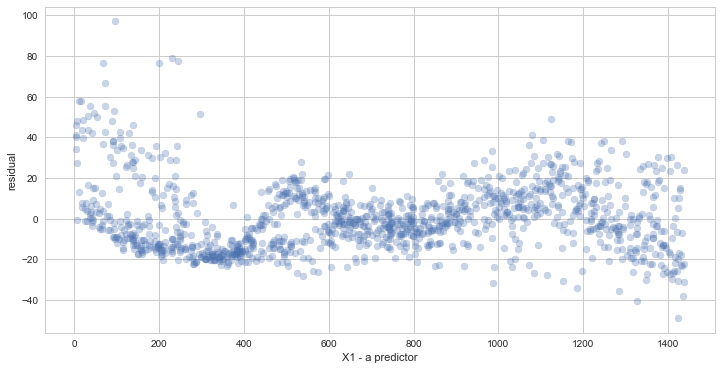

In [24]:
sns.set(style="whitegrid")
matplotlib.rcParams['figure.figsize']=(12,6)
plt.scatter(data['TimeMin'], residual, alpha=.3)
plt.xlabel("X1 - a predictor")
plt.ylabel("residual")
plt.show()

**3.7 Discuss the results:**

1. How does the test $R^2$ score compare with the best test $R^2$ value obtained with k-NN regression?
2. What does the sign of the slope of the fitted linear model convey about the data?  
3. Based on the $95\%$ confidence interval, do you consider the estimates of the model parameters to be reliable?  
4. Do you expect $99\%$ confidence intervals for the slope and intercept to be tighter or wider than the $95\%$ confidence intervals? Briefly explain your answer.  
5. Based on the residuals plot that you made, discuss whether or not the assumption of linearity is valid for this data.
6. Based on the data structure, what restriction on the model would you put at the endpoints (at $x\approx0$ and $x\approx1440$)?   What does this say about the linearity assumption?

**Answers to Discussion Questions**
1. $R^2$ for OLS regression is .24, so it's lower than the best test $R^2$ obtained with the kNN regression where k = 75 and the $R^2$ is .39.
2. The relationship is positive, indicating that as the time of day increases, pick-ups increase.
3. Yes, we believe they are reliable based on the CI. Our confidence intervale for pick-ups has a range of ~4 pick ups on a scale of hundreds, and our interval for time is .005. Relative to our scale we used to measure these values, the CIs are tight. Our small P value backs this up.
4. Wider. We believe that the true value of Beta_1 falls into this interval with 99% certainty; thus it encompasses more values than the 95% CI.
5. Based on the residual plot, it seems that the assumption of linearity is not valid. A curvilinear relationship modeled by a polynomial regression would be more appropriate.
6. Based on the data structure, we would say that y at 0 must be equate to y at 1440. This also shows that the linearity assumption is not valid, because the only way this is possible with a linear model is if we have a straight horizontal line (the mean).

<div class="theme"> Outliers </div>

You may recall from lectures that OLS Linear Regression can be susceptible to outliers in the data.  We're going to look at a dataset that includes some outliers and get a sense for how that affects modeling data with Linear Regression.  **Note, this is an open-ended question, there is not one correct solution (or one correct definition of an outlier).**


<div class="exercise"><b> Question 4 [25 pts] </b></div>




**4.1**. We've provided you with two files `outliers_train.txt` and `outliers_test.txt` corresponding to training set and test set data.  What does a visual inspection of training set tell you about the existence of outliers in the data?

**4.2**. Choose `X` as your feature variable and `Y` as your response variable.  Use `statsmodel` to create a Linear Regression model on the training set data.  Store your model in the variable `OutlierOLSModel`.

**4.3**. You're given the knowledge ahead of time that there are 3 outliers in the training set data.  The test set data doesn't have any outliers.  You want to remove the 3 outliers in order to get the optimal intercept and slope.  In the case that you're sure of the existence and number (3) of outliers ahead of time, one potential brute force method to outlier detection might be to find the best Linear Regression model on all possible subsets of the training set data with 3 points removed.  Using this method, how many times will you have to calculate the Linear Regression coefficients on the training data?

**4.4**  In CS109 we're strong believers that creating heuristic models is a great way to build intuition. In that spirit, construct an approximate algorithm to find the 3 outlier candidates in the training data by taking advantage of the Linear Regression residuals. Place your algorithm in the function `find_outliers_simple`.  It should take the parameters `dataset_x` and `dataset_y` representing your features and response variable values (make sure your response variable is stored as a numpy column vector).  The return value should be a list `outlier_indices` representing the indices of the 3 outliers in the original datasets you passed in.  Remove the outliers that your algorithm identified, use `statsmodels` to create a Linear Regression model on the remaining training set data, and store your model in the variable `OutlierFreeSimpleModel`.


**4.5** Create a figure with two subplots: the first is a scatterplot where the color of the points denotes the outliers from the non-outliers in the training set, and include two regression lines on this scatterplot: one fitted with the outliers included and one fitted with the outlier removed (all on the training set).  The second plot should include a scatterplot of points from the test set with the same two regression lines fitted on the training set: with and without outliers.  Visually which model fits the test set data more closely?



**4.6**. Calculate the $R^2$ score for the `OutlierOLSModel` and the `OutlierFreeSimpleModel` on the test set data.  Which model produces a better $R^2$ score?

**4.7**. One potential problem with the brute force outlier detection approach in 4.3 and the heuristic algorithm you constructed 4.4 is that they assume prior knowledge of the number of outliers.  In general you can't expect to know ahead of time the number of outliers in your dataset.  Alter the algorithm you constructed in 4.4 to create a more general heuristic (i.e. one which doesn't presuppose the number of outliers) for finding outliers in your dataset.  Store your algorithm in the function `find_outliers_general`.  It should take the parameters `dataset_x` and `dataset_y` representing your features and response variable values (make sure your response variable is stored as a numpy column vector).  It can take additional parameters as long as they have default values set.  The return value should be the list `outlier_indices` representing the indices of the outliers in the original datasets you passed in (in the order of 'severity').  Remove the outliers that your algorithm identified, use `statsmodels` to create a Linear Regression model on the remaining training set data, and store your model in the variable `OutlierFreeGeneralModel`.

**Hints**:
   1. How many outliers should you try to identify in each step?
   2. If you plotted an $R^2$ score for each step the algorithm, what might that plot tell you about stopping conditions?
    
**4.8**. Run your algorithm in 4.7 on the training set data.  
1. What outliers does it identify?
2. How do those outliers compare to the outliers you found in 4.4?
3. How does the general outlier-free Linear Regression model you created in 4.7 perform compared to the simple one in 4.4?

### Answers
**4.1  We've provided you with two files `outliers_train.txt` and `outliers_test.txt` corresponding to training set and test set data.  What does a visual inspection of training set tell you about the existence of outliers in the data? ** 

In [25]:
# read the data
# your code here

train_data = pd.read_csv('data/outliers_train.csv', sep=",")
test_data = pd.read_csv('data/outliers_test.csv', sep=",")

In [26]:
train_data_vec = train_data.values
test_data_vec = test_data.values

In [27]:
train_data_vec

array([[ -7.73019298e-01,  -2.19103753e+02],
       [ -3.94034327e-01,  -3.34859357e+02],
       [  6.30359981e-01,  -1.62325488e+01],
       [ -3.50417771e-01,  -1.79034618e+02],
       [ -1.49132794e+00,  -1.09710316e+02],
       [ -1.19129313e-01,  -2.50992560e+02],
       [ -1.74254703e+00,  -1.59764549e+01],
       [  1.08550184e+00,   2.43835916e+02],
       [ -3.18393199e-01,   7.89361279e+01],
       [ -1.46942120e+00,  -2.07045450e+02],
       [  4.83420193e-01,   1.18129405e+02],
       [ -9.44166768e-01,   5.52398455e+01],
       [  1.18519609e-02,   4.08264009e+01],
       [  1.89446482e+00,   5.62064880e+01],
       [ -3.91667753e-01,  -2.95878637e+02],
       [  1.90832942e-01,  -9.11610757e+01],
       [ -3.58105327e-02,   2.84547457e+01],
       [  1.11410748e+00,   2.94354479e+01],
       [ -1.30737478e+00,  -9.96955445e+01],
       [  1.77751149e-01,   1.30016397e+02],
       [ -5.31202022e-01,  -2.30593281e+02],
       [ -9.15095516e-01,  -1.44897865e+02],
       [  

Text(0,0.5,'Number of Taxi Pick Ups')

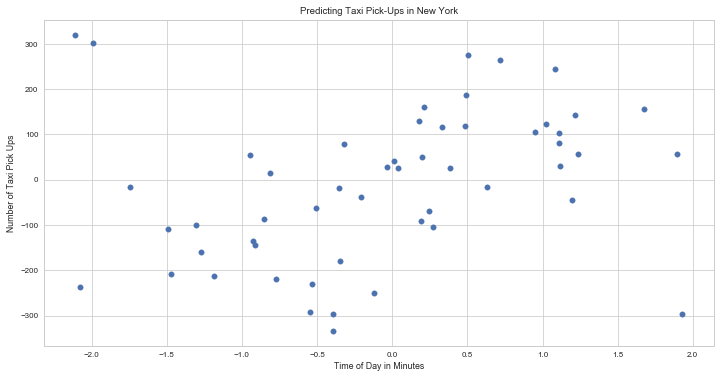

In [28]:
sns.set_context("paper")
plt.scatter(train_data["X"],train_data["Y"])
plt.title('Predicting Taxi Pick-Ups in New York')
plt.xlabel("Time of Day in Minutes")
plt.ylabel("Number of Taxi Pick Ups")

**A visual inspection** shows that there are definitely outliers: two data points at the top left of the graph and one at the bottom right.


**4.2 Choose `X` as your feature variable and `Y` as your response variable.  Use `statsmodel` to create a Linear Regression model on the training set data.  Store your model in the variable `OutlierOLSModel`**

In [29]:
# your code here
#Split Data into X,Y
x_train, y_train = train_data['X'], train_data['Y']
x_test, y_test = test_data['X'], test_data['Y']

#Add constant
x_train_ca = sm.add_constant(x_train)
x_test_ca = sm.add_constant(x_test)

In [30]:
display(x_train_ca, y_train)

,const,X
0,1.0,-0.773019
1,1.0,-0.394034
2,1.0,0.630360
3,1.0,-0.350418
4,1.0,-1.491328
5,1.0,-0.119129
6,1.0,-1.742547
7,1.0,1.085502
8,1.0,-0.318393
9,1.0,-1.469421


0    -219.103753
1    -334.859357
2     -16.232549
3    -179.034618
4    -109.710316
5    -250.992560
6     -15.976455
7     243.835916
8      78.936128
9    -207.045450
10    118.129405
11     55.239846
12     40.826401
13     56.206488
14   -295.878637
15    -91.161076
16     28.454746
17     29.435448
18    -99.695545
19    130.016397
20   -230.593281
21   -144.897865
22    -43.616020
23    105.731108
24    263.449637
25   -160.108014
26    161.236068
27    142.080757
28    275.862982
29    -19.299877
30     14.303940
31     51.316092
32     25.798098
33    103.330164
34    117.361476
35   -291.094951
36     25.369347
37    -62.017523
38    156.919503
39    -87.135757
40    124.064067
41    187.422157
42   -213.000722
43     80.852281
44    -37.364889
45     56.872020
46   -237.873393
47   -134.582390
48    -68.253894
49   -104.393096
50    320.000000
51    303.000000
52   -297.000000
Name: Y, dtype: float64

In [31]:
OutlierOLSModel = sm.OLS(y_train, x_train_ca)
results = OutlierOLSModel.fit()
display(results.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.084
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     4.689
Date:                Thu, 27 Sep 2018   Prob (F-statistic):             0.0351
Time:                        12:08:57   Log-Likelihood:                -343.59
No. Observations:                  53   AIC:                             691.2
Df Residuals:                      51   BIC:                             695.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -9.5063     22.192     -0.428      0.670     -54.059      35.046
X             47.3554     21.869      2.165      0.035       3.452      91.259
==============================================================================
Omnibus:                        2.102   Durbin-Watson:                   1.758
Prob(Omnibus):                  0.350   Jarque-Bera (JB):                1.251
Skew:                           0.215   Prob(JB):                        0.535
Kurtosis:                       3.617   Cond. No.                         1.06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**4.3 One potential brute force method to outlier detection might be to find the best Linear Regression model on all possible subsets of the training set data with 3 points removed.  Using this method, how many times will you have to calculate the Linear Regression coefficients on the training data?**
  
  

Because the the dataset has 53 values, and we want to remove 3, we want to find all non-repeatable possibilities of the dataset when there are 50 values in it.

In order to do this, $\frac{n!}{k!(n-k)!}$, where $n=53$ and $k=3$, which gives us 23,426 possibilities.

**4.4 In CS109 we're strong believers ...**

In [32]:
# your code here
#Split Data into X,Y
x_train, y_train = train_data_vec[:53,:1], train_data_vec[:53,1:2]
x_test, y_test = test_data_vec[:50,:1], test_data_vec[:50,1:2]

#Add constant
x_train_ca = sm.add_constant(x_train)
x_test_ca = sm.add_constant(x_test)

In [33]:
#checking on some functions
x_train_sorted = sorted(x_train)[:3]

x_train_sorted

[array([-2.11]), array([-2.07814432]), array([-1.991])]

In [34]:
def find_outliers_simple(dataset_x, dataset_y):
    x_ca = sm.add_constant(dataset_x)
    OutliersOLSModel = sm.OLS(dataset_y, x_ca)
    results = OutliersOLSModel.fit()
    residualslist = []
    
    pred_y = results.predict(x_ca)
    for i in range (0,len(dataset_y)):
        residual = pred_y[i] - dataset_y[i]
        resid_square = residual**2
        residualslist.append(resid_square)
    
    outlierlist=[]
    for i in range (3):
        outlierlist.append(np.argmax(residualslist))
        residualslist[outlierlist[-1]] = -float('inf')
    
    return outlierlist
    

In [35]:
outlier_free_data = find_outliers_simple(x_train_ca, y_train)

In [36]:
x_train_ca_new = x_train_ca[0:50]
y_train_new = y_train[0:50]

In [37]:
# calculate outlier model
# your code here
OutlierFreeSimpleModel = sm.OLS(y_train_new, x_train_ca_new)
OutlierFreeresults = OutlierFreeSimpleModel.fit()
display(OutlierFreeresults.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.404
Model:                            OLS   Adj. R-squared:                  0.391
Method:                 Least Squares   F-statistic:                     32.50
Date:                Thu, 27 Sep 2018   Prob (F-statistic):           7.16e-07
Time:                        12:08:58   Log-Likelihood:                -309.21
No. Observations:                  50   AIC:                             622.4
Df Residuals:                      48   BIC:                             626.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -17.4796     16.944     -1.032      0.307     -51.547      16.588
x1           104.8467     18.392      5.701      0.000      67.867     141.827
==============================================================================
Omnibus:                        0.600   Durbin-Watson:                   1.683
Prob(Omnibus):                  0.741   Jarque-Bera (JB):                0.673
Skew:                          -0.238   Prob(JB):                        0.714
Kurtosis:                       2.689   Cond. No.                         1.09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**4.5** Create a figure with two subplots: the first is a scatterplot where the color of the points denotes the outliers from the non-outliers in the training set, and include two regression lines on this scatterplot: one fitted with the outliers included and one fitted with the outlier removed (all on the training set).  The second plot should include a scatterplot of points from the test set with the same two regression lines fitted on the training set: with and without outliers.  Visually which model fits the test set data more closely?

In [38]:
#Define variables
x_ca = sm.add_constant(x_train)
pred_y = results.predict(x_ca)
OutlierFreepred_y = OutlierFreeresults.predict(x_train_ca_new)

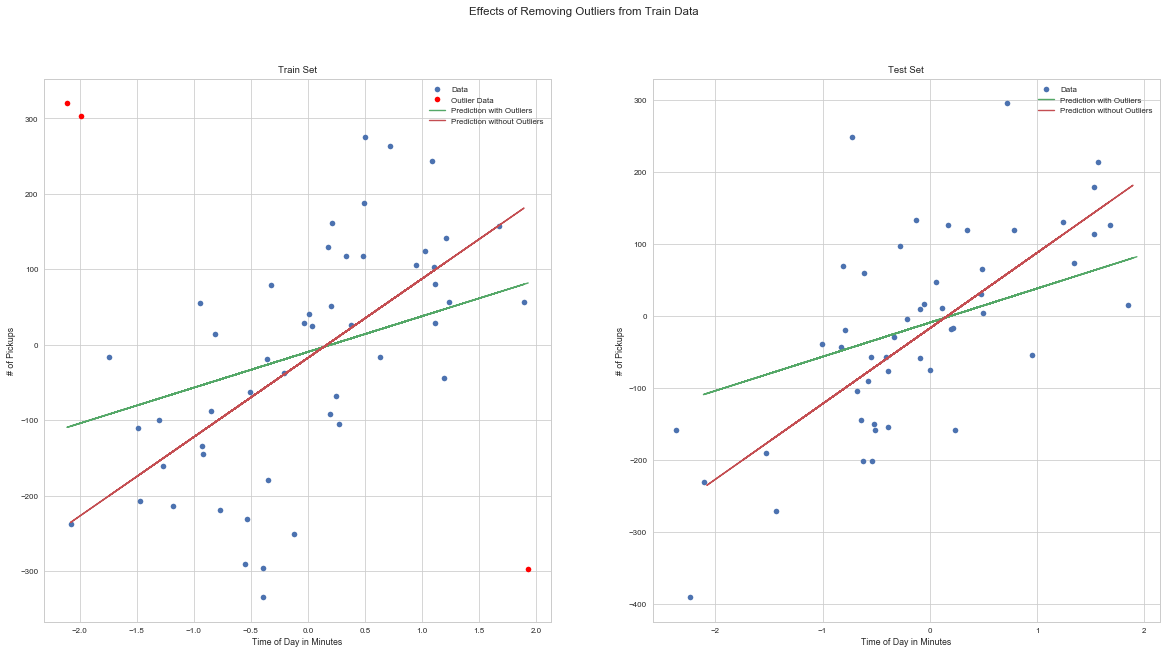

In [39]:
# plot 
# your code here
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,10));
axes[0].plot(train_data['X'][0:50], train_data['Y'][0:50],'o', label = 'Data' );
axes[0].plot(train_data['X'][50:53], train_data['Y'][50:53],'o', color = 'red', label = 'Outlier Data' );
axes[0].plot(train_data['X'], pred_y, '-', label = 'Prediction with Outliers');
axes[0].plot(train_data['X'][0:50], OutlierFreepred_y, '-', label = 'Prediction without Outliers');
axes[0].set_xlabel('Time of Day in Minutes');
axes[0].set_ylabel('# of Pickups');
axes[0].set_title("Train Set");
axes[0].legend();

axes[1].plot(x_test, y_test,'o', label = 'Data' );
axes[1].plot(train_data['X'], pred_y, '-', label = 'Prediction with Outliers');
axes[1].plot(train_data['X'][0:50], OutlierFreepred_y, '-', label = 'Prediction without Outliers');
axes[1].set_xlabel('Time of Day in Minutes');
axes[1].set_ylabel('# of Pickups');
axes[1].set_title("Test Set");
axes[1].legend();

fig.suptitle("Effects of Removing Outliers from Train Data");

Visually, it appears that both models fit the test set very closely. The outliers in the test set did not have a significant impact on the linear regression.

**4.6  Calculate the $R^2$ score for the `OutlierOLSModel` and the `OutlierFreeSimpleModel` on the test set data.  Which model produces a better $R^2$ score?**

In [40]:
r2_without_outlier = r2_score(test_data['Y'], OutlierFreeresults.params[0] + OutlierFreeresults.params[1] * test_data['X'])
r2_with_outlier = r2_score(test_data['Y'], results.params[0] + results.params[1] * test_data['X'])
print("R^2 Score for Test Data using Model with Outliers 'OutlierOLSModel':", r2_with_outlier)
print("R^2 Score for Test Data using Model without Outliers 'OutlierFreeSimpleModel':", r2_without_outlier)

R^2 Score for Test Data using Model with Outliers 'OutlierOLSModel': 0.340856560434
R^2 Score for Test Data using Model without Outliers 'OutlierFreeSimpleModel': 0.452956687017


The `OutlierFreeSimpleModel` produces a better $R^2$ score, which makes sense becuase we have removed outliers.


**4.7 One potential problem with the brute force outlier detection approach in 4.3 and the heuristic algorithm you constructed 4.4 is that they assume prior knowledge of the number of outliers.  Ingeneral you can't expect to know ahead of time the number of outliers in your dataset.  Alter the algorithm you constructed in 4.4 to create a more general heuristic (i.e. one which doesn't presuppose the number of outliers) for finding outliers in your dataset..**

In [41]:
def find_outliers_general(dataset_x, dataset_y):
    x_ca = sm.add_constant(dataset_x)
    OutliersOLSModel = sm.OLS(dataset_y, x_ca)
    results = OutliersOLSModel.fit()
    residualslist = []
    
    pred_y = results.predict(x_ca)
    for i in range (0,len(dataset_y)):
        residual = pred_y[i] - dataset_y[i]
        resid_square = residual**2
        mse = resid_square.mean
        residualslist.append(resid_square)
    return residualslist
        
    outlierlist=[]
    for i in range (0,len(dataset_y)):
        if residualslist[i] > 1000:
            outliers = resid_squared
            outlierlist.append(outliers)
        else:
            pass
    
    return residualslist
    

In [42]:
df_train = pd.read_csv('data/outliers_train.csv')    

In [43]:
def find_outliers_general(dataset_x, dataset_y):
    data_for_outliers = sm.add_constant(dataset_x)
    model = OLS(endog=dataset_y, exog=dataset_x)
    OLSmodel = model.fit()
    predicted = OLSmodel.predict()
    residuals = abs(dataset_y - predicted)
    outlier_index = OLSmodel.outlier_test()
    outliers = outlier_index['bonf(p)']
    outlier_indices = np.argsort(outliers).values
    return outlier_indices

In [44]:
answer = find_outliers_general(df_train['X'],df_train['Y'])

**4.8 Run your algorithm in 4.7 on the training set data **
1. What outliers does it identify?
2. How do those outliers compare to the outliers you found in 4.4?
3. How does the general outlier-free Linear Regression model you created in 4.7 perform compared to the simple one in 4.4?

(0.15, 0.45)

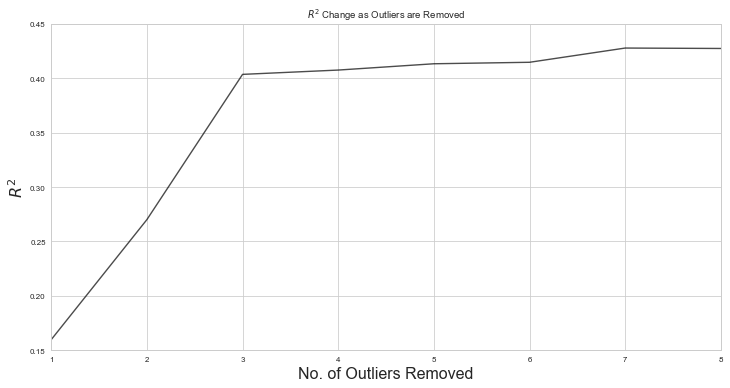

In [45]:
outliers = find_outliers_general(df_train['X'],df_train['Y'])
r2 = []; list_outliers = []

for i in range(len(outliers)-1):
    new_outliers = df_train.drop(df_train.index[outliers[:i+1]])
    x_new = sm.add_constant(new_outliers[['X']].values)
    results_new = OLS(new_outliers['Y'].values, x_new).fit()
    r2.append(results_new.rsquared)
    list_outliers.append(i+1)
    if r2[i] < r2[i-1]:
        break

plt.plot(list_outliers, r2, alpha = 0.7, c='k');
plt.xlabel('No. of Outliers Removed', size = 16);
plt.ylabel('$R^2$', size=16);
plt.title('$R^2$ Change as Outliers are Removed');
plt.grid('on'); plt.xlim([1,8]); plt.ylim([0.15, 0.45])

In [46]:
print(list_outliers)

[1, 2, 3, 4, 5, 6, 7, 8]


In [47]:
# your code here
df_train = pd.read_csv('data/outliers_train.csv')
removed_outliers = outliers[0:len(list_outliers)-1]
edit1 = df_train.drop(df_train.index[removed_outliers])
edit1 = sm.add_constant(edit1)
OutlierFreeGeneralModel = OLS(endog=edit1['Y'], exog=edit1[['const', 'X']])
OutlierFreeresults = OutlierFreeGeneralModel.fit()
display(OutlierFreeresults.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.428
Model:                            OLS   Adj. R-squared:                  0.415
Method:                 Least Squares   F-statistic:                     32.91
Date:                Thu, 27 Sep 2018   Prob (F-statistic):           8.21e-07
Time:                        12:08:59   Log-Likelihood:                -283.52
No. Observations:                  46   AIC:                             571.0
Df Residuals:                      44   BIC:                             574.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -24.3562     17.330     -1.405      0.167     -59.283      10.571
X            104.8842     18.282      5.737      0.000      68.038     141.730
==============================================================================
Omnibus:                        0.968   Durbin-Watson:                   1.755
Prob(Omnibus):                  0.616   Jarque-Bera (JB):                1.002
Skew:                          -0.312   Prob(JB):                        0.606
Kurtosis:                       2.634   Cond. No.                         1.06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Answers**
1. It identifies the same outliers as the earlier model, but also 3 additional outliers. However, it is slightly ambigious as to whether these are actually outliers, as the change in $R^2$ is not very drastic after the first 3 outliers are removed.
2. These outliers includes the ones from 4.4, plus 3 additional data points.
3. The outlier free model performs better, as evidenced by a lower $R^2$ value. However, the slight change in $R^2$ after the first 3 outliers are removed, may not warrant taking out any additional values, as we're losing data.